In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *
from gridsearch import grid_search

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [2]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

### Separating training set and test set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

### Rescaling the output to the [0,1] range

In [4]:
from sklearn.preprocessing import MinMaxScaler

rescaler = MinMaxScaler()
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
rescaler.fit(y_train)
y_train = rescaler.transform(y_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

Combination: [64, 64, 3] ReLU Fan_in (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.0005


Epochs:  12%|█▏        | 1184/10000 [00:36<04:32, 32.39it/s]


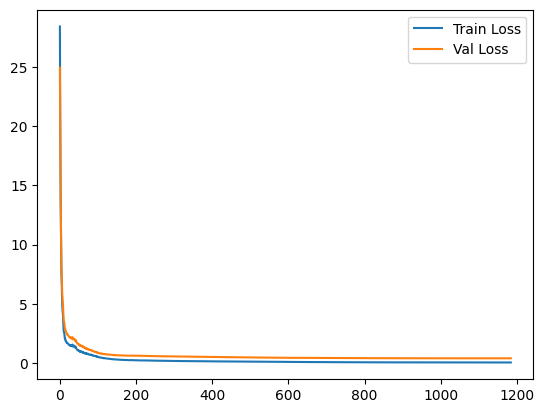

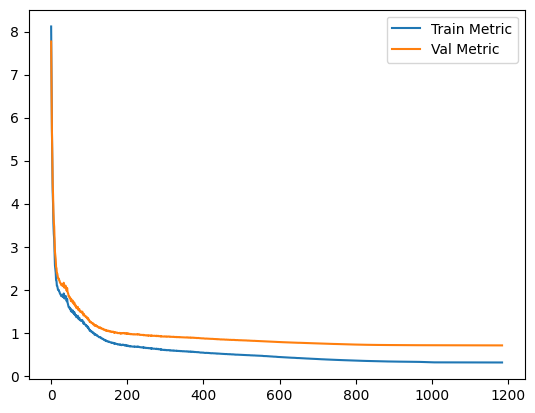

Fold 1 of 6 completed
Train Loss: 0.05128428316124427
Train Metric: 0.32517721127055493
Val Loss: 0.40062615459148204
Val Metric: 0.7104069470844782


Epochs:  14%|█▍        | 1427/10000 [00:45<04:31, 31.63it/s]


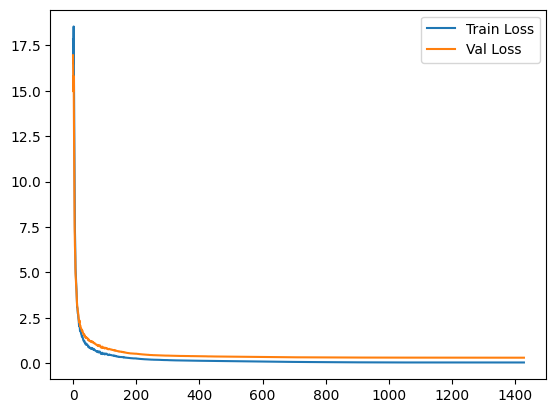

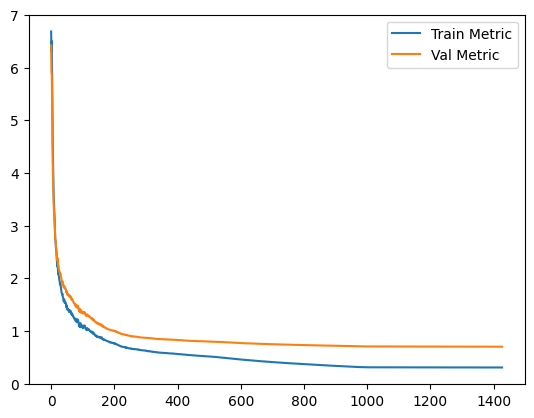

Fold 2 of 6 completed
Train Loss: 0.04176089860651679
Train Metric: 0.308480603378464
Val Loss: 0.3069496390077911
Val Metric: 0.7041452489064258


Epochs:  13%|█▎        | 1336/10000 [00:42<04:35, 31.46it/s]


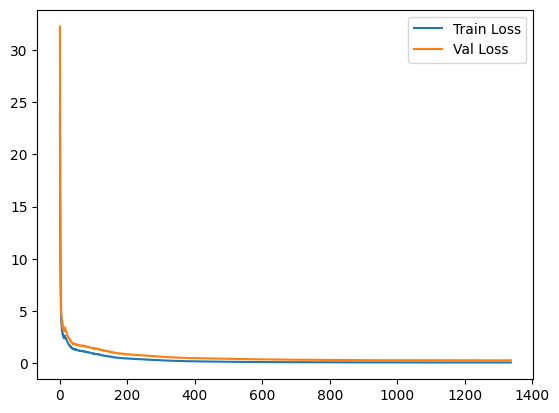

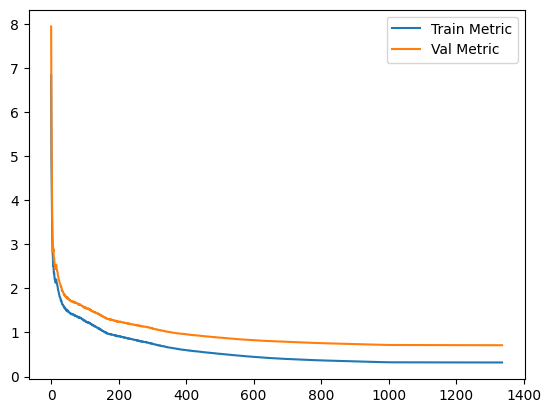

Fold 3 of 6 completed
Train Loss: 0.04384829125511261
Train Metric: 0.3218771008128846
Val Loss: 0.25484759607010055
Val Metric: 0.713871648769426


Epochs:  12%|█▏        | 1230/10000 [00:39<04:42, 31.06it/s]


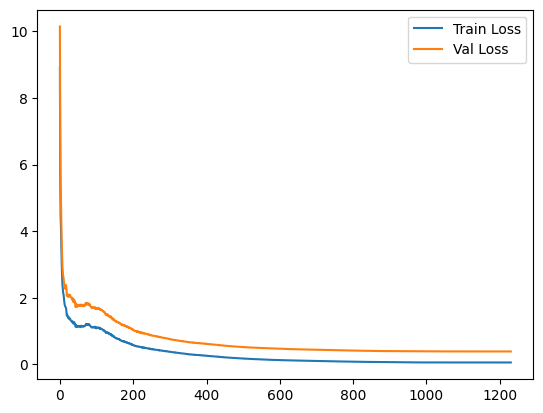

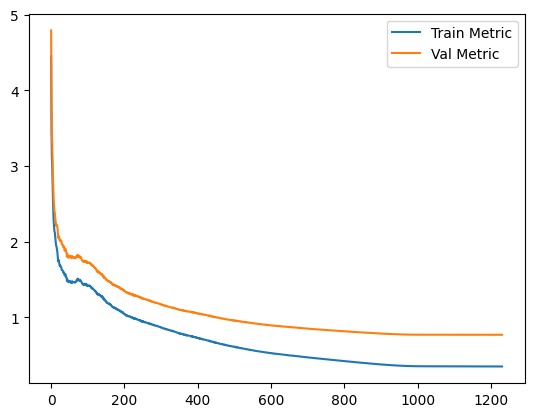

Fold 4 of 6 completed
Train Loss: 0.05645546894176964
Train Metric: 0.3569412231997341
Val Loss: 0.3894802756545012
Val Metric: 0.7724550701657099


Epochs:  13%|█▎        | 1347/10000 [00:43<04:40, 30.87it/s]


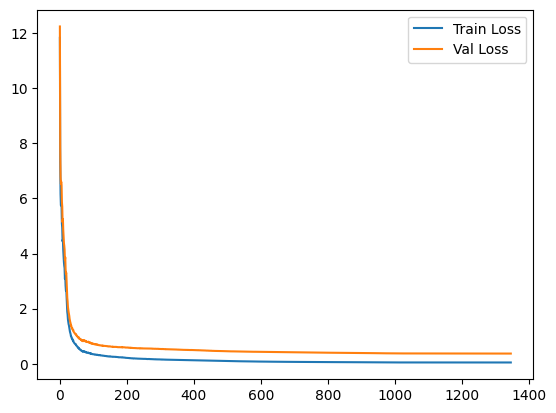

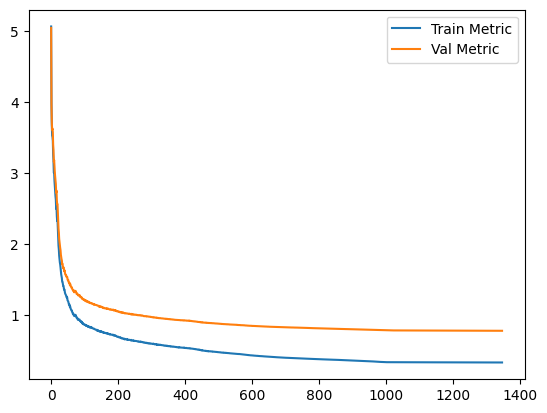

Fold 5 of 6 completed
Train Loss: 0.04704084441129195
Train Metric: 0.32808670870741513
Val Loss: 0.3731389546197278
Val Metric: 0.7760714538012266


Epochs:  15%|█▍        | 1465/10000 [00:47<04:36, 30.91it/s]


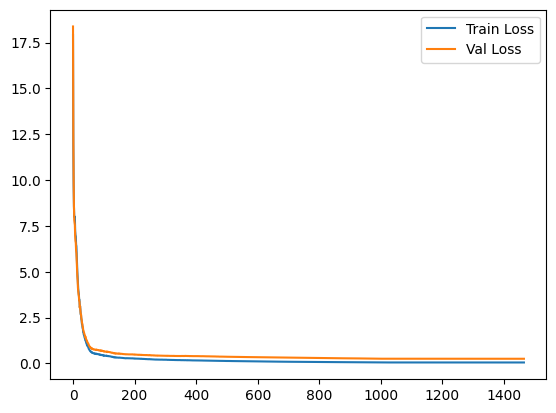

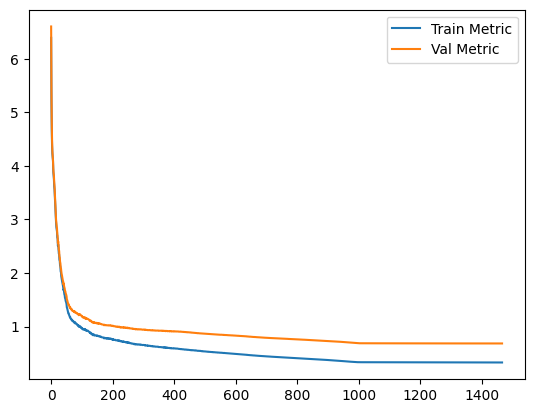

Fold 6 of 6 completed
Train Loss: 0.0483653180191368
Train Metric: 0.3313999306945192
Val Loss: 0.2512298347145236
Val Metric: 0.6858930817447275
Combination: [64, 64, 3] ReLU Fan_in (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.0005
Statistics: {'tr_loss': 0.048125850732512014, 'tr_metric': 0.3286604630105953, 'val_loss': 0.32937874244302107, 'val_metric': 0.7271405750786656}





In [4]:
hyperparameters = {
    'layers_sizes': [[64, 64, 3]],
    'activations': ["ReLU"], 
    'startings': ["Fan_in"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-8],
    'momentums': [('Nesterov', 0.9)],
    'etas': [5e-4],
}

data_to_csv = grid_search(
    hyperparams=hyperparameters,
    X=X_train,
    y=y_train,
    k=6,
    metric=MEE(),
    loss=MSE(1),
    seed=6,
    verbose=True
)

In [ ]:
# reshape ytrain eliminating last shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_train.shape

In [ ]:
# reshape Xtrain eliminating last shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_train.shape

In [ ]:
# use scikit-lear to make regression in 3d
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    solver='sgd',
    alpha=0,
    batch_size=1,
    learning_rate_init=1e-3,
    max_iter=2500,
    shuffle=True,
    random_state=6,
    verbose=True,
    momentum=0,
    beta_1= 0,
    beta_2= 0.,
    epsilon= 1,
    validation_fraction = 0,
    nesterovs_momentum=False
)

mlp.fit(X_train, y_train)
# print the learning curve
plt.plot(mlp.loss_curve_)
plt.show()

# print the mean error
print(MEE()(y_train, mlp.predict(X_train)))

In [31]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    